In [1]:
import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
import flowpm.raytracing as raytracing
import pickle
from flowpm.tfpower import linear_matter_power
import astropy.units as u
import tensorflow_addons as tfa
import flowpm.constants as constants
from itertools import cycle

In [2]:
n_lens = 22       # Number of lensplanes in the lightcone
box_size=100.     # Transverse comoving size of the simulation volume
nc = 64       # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
field_npix =512 #1024  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel
Omega_c=0.2589
sigma8=0.8159


In [6]:
@tf.function
def compute_kappa(Omega_c,sigma8):
    """ Computes a convergence map using ray-tracing through an N-body for a given
    set of cosmological parameters
    """
    # Instantiates a cosmology with desired parameters
    cosmology = flowpm.cosmology.Planck15(Omega_c=Omega_c,sigma8=sigma8)

    # Schedule the center of the lensplanes we want for ray tracing
    r = tf.linspace(0., box_size*n_lens, n_lens+1)
    r_center = 0.5*(r[1:] + r[:-1])

    # Retrieve the scale factor corresponding to these distances
    a = flowpm.tfbackground.a_of_chi(cosmology, r)
    a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
    
    # We run 4 steps from initial scale factor to start of raytracing
    init_stages = tf.linspace(0.1, a[-1], 4)
    # Then one step per lens plane
    stages = tf.concat([init_stages, a_center[::-1]], axis=0)
    
    
    k = tf.constant(np.logspace(-4, 1, 256), dtype=tf.float32)
    pk = linear_matter_power(cosmology, k)
    pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)

    
    # Create some initial conditions
#     initial_conditions = flowpm.linear_field([nc, nc, nc],
#                                          [box_size, box_size, box_size], 
#                                          lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
#                                          batch_size=batch_size)
    initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         pk_fun,         
                                         batch_size=batch_size)
    initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)
    
    # Run the Nbody
    states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 
    
    # Extract the lensplanes
    lensplanes = []
    matrix=flowpm.raytracing.generate_matrix()
    for i,j in zip(range(len(a_center)),cycle(range(6))):
        plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2, #r_center[i]/box_size*nc,
                                            matrix[j],
                                            flowpm.raytracing.shift(),
                                            width=nc,
                                            plane_resolution=256)

        plane = tf.expand_dims(plane, axis=-1)
        lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))
    xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

    coords = np.stack([xgrid, ygrid], axis=0)*u.deg
    c = coords.reshape([2, -1]).T.to(u.rad)
    # Create array of source redshifts
    z_source = tf.linspace(0.5, 1, 4)
    m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)
   
    m=tf.reshape(m,[batch_size, field_npix, field_npix, -1])
    
    return m,  lensplanes, r_center, a_center


In [7]:
@tf.function
def compute_jacobian(Omega_c, sigma8):
    """ Function that actually computes the Jacobian of a given statistics
    """
    params = tf.stack([Omega_c, sigma8])
    with tf.GradientTape() as tape:
        tape.watch(params)
        m, lensplanes, r_center, a_center = compute_kappa(params[0], params[1])
        ell, power_spectrum= DHOS.statistics.power_spectrum(m[0,:,:,-1],field_size,
                                                         field_npix)
        
        k1 =tf.where(ell < 650 ,False, True)
        ell=tf.boolean_mask(ell, tf.math.logical_not(k1))
        power_spectrum =tf.boolean_mask(power_spectrum, tf.math.logical_not(k1))
        
    return m,lensplanes, r_center, a_center, tape.jacobian(power_spectrum, params,
                             experimental_use_pfor=False), ell, power_spectrum


In [8]:
 m,lensplanes, r_center, a_center,jac,ell,ps=compute_jacobian(Omega_c, sigma8)

In [10]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


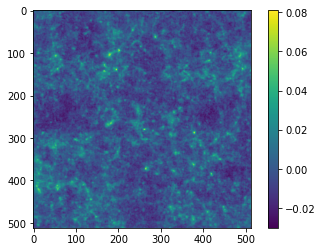

In [20]:
imshow(m[0,:,:,3]);colorbar()

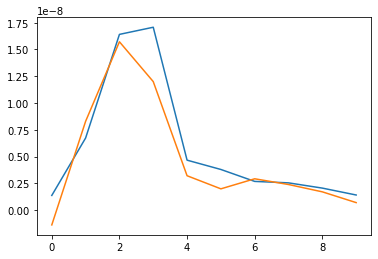

In [17]:
plot(jac[:,0])
plot(jac[:,1])